Cross-Validation Accuracy: 0.91 ± 0.00
Classification Report:
               precision    recall  f1-score   support

    Negative       0.93      1.00      0.96      1454
     Neutral       0.88      0.96      0.92      1442
    Positive       0.96      0.78      0.86      1435

    accuracy                           0.92      4331
   macro avg       0.92      0.92      0.91      4331
weighted avg       0.92      0.92      0.91      4331



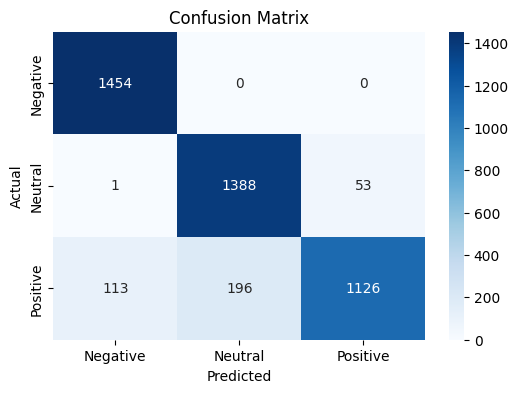

In [8]:
import json
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Map numeric labels to real class names
label_mapping = {0: "Negative", 1: "Neutral", 2: "Positive"}

# Load the data
file_path = 'Datasets/train_data.json'
with open(file_path, 'r', encoding='utf-8') as file:
    lines = file.readlines()

# Prepare features and labels
texts = []
labels = []

for line in lines:
    try:
        record = json.loads(line)
        label = record.get("label")
        labels.append(label)
        # Use the review text as the feature
        texts.append(record.get("reviewText", ""))
    except json.JSONDecodeError:
        continue

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
features = vectorizer.fit_transform(texts).toarray()

# Apply SMOTE for balancing
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(features, labels)

# Feature Scaling
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Logistic Regression with L2 regularization
model = LogisticRegression(max_iter=1000, random_state=42, penalty='l2', C=1.0)
model.fit(X_train, y_train)

# Cross-validation for model evaluation
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {np.mean(cv_scores):.2f} ± {np.std(cv_scores):.2f}")

# Model prediction
y_pred = model.predict(X_test)

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_mapping.values()))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_mapping.values(), yticklabels=label_mapping.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
